In [473]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [474]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

In [475]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed


In [476]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form_with_vocab(data_frame, vocab):
    count_vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [477]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [478]:
def scale(data,mean,std_dev):
    diff = data - mean
    scaled = diff / std_dev
    return scaled

In [479]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size=.75)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.70)

In [480]:
active_train_df = pd.DataFrame(active_train)
active_test_df = pd.DataFrame(active_test)
active_binding_train_df = pd.DataFrame(active_binding_train)
active_binding_test_df = pd.DataFrame(active_binding_test)

active_train_df['binding'] = active_binding_train_df['binding']
active_test_df['binding'] = active_binding_test_df['binding']

In [481]:
not_active_train_df = pd.DataFrame(not_active_train)
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_train_df = pd.DataFrame(not_active_binding_train)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)

not_active_train_df['binding'] = not_active_binding_train_df['binding']
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [482]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    505
1     58
Name: binding, dtype: int64
0    217
1     20
Name: binding, dtype: int64


In [483]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy=.5)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1,1),train_df.binding)
x_test_sampled, y_test_sampled = sampler.fit_resample(np.array(test_df.sequence).reshape(-1,1),test_df.binding)

In [484]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(x_test_sampled, columns  =["sequence"])
final_test_set['binding'] = y_test_sampled
print(final_test_set.binding.value_counts())

0    505
1    252
Name: binding, dtype: int64
0    217
1    108
Name: binding, dtype: int64


In [494]:
vectorizer_global, training_features = return_binary_vectorized_form(final_train_set.sequence)
k_best_feature = select_k_best_features(training_features, final_train_set.binding, 1, vectorizer_global.get_feature_names_out())
vectorizer_k_best, training_split = return_binary_vectorized_form_with_vocab(final_train_set.sequence,k_best_feature)
test_split = vectorizer_k_best.transform(final_test_set.sequence).toarray()

In [495]:
print(training_split.shape)
print(test_split.shape)

(757, 80933)
(325, 80933)


In [496]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
# print(train_result.shape)
# print(test_result.shape)


In [497]:
test_result.sum()

108

In [498]:
training_split

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [499]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=.95)
# training_split = pca.fit_transform(training_split)
# test_split = pca.transform(test_split)

In [500]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(training_split.shape[-1],)),
    tf.keras.layers.Dense(2,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.05)),
    # tf.keras.layers.Dropout(0.8),

    # kernel_regularizer=tf.keras.regularizers.L1(.1)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [501]:
from sklearn.metrics import f1_score
# def x(a,b):
#     tf.make_ndarray(a.op.get_attr('value'))
#     y = tf.make_ndarray(a.op.get_attr('value'))
#     return y.shape[-1]
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'),
      # x
     # precision-recall curve

]
model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

In [506]:
num_epochs = 50
history = model.fit(training_split, train_result, epochs=num_epochs, validation_data=(test_split, test_result))
# ,callbacks=[tf.keras.callbacks.EarlyStopping()]

Epoch 1/50
24/24 [==============================] - 1s 28ms/step - loss: 1.1955 - tp: 154.0000 - fp: 10.0000 - tn: 495.0000 - fn: 98.0000 - accuracy: 0.8573 - precision: 0.9390 - recall: 0.6111 - auc: 0.8893 - prc: 0.8812 - val_loss: 1.1951 - val_tp: 72.0000 - val_fp: 6.0000 - val_tn: 211.0000 - val_fn: 36.0000 - val_accuracy: 0.8708 - val_precision: 0.9231 - val_recall: 0.6667 - val_auc: 0.8579 - val_prc: 0.8463
Epoch 2/50
24/24 [==============================] - 1s 23ms/step - loss: 1.1846 - tp: 164.0000 - fp: 10.0000 - tn: 495.0000 - fn: 88.0000 - accuracy: 0.8705 - precision: 0.9425 - recall: 0.6508 - auc: 0.9113 - prc: 0.8946 - val_loss: 1.1917 - val_tp: 72.0000 - val_fp: 6.0000 - val_tn: 211.0000 - val_fn: 36.0000 - val_accuracy: 0.8708 - val_precision: 0.9231 - val_recall: 0.6667 - val_auc: 0.9107 - val_prc: 0.8356
Epoch 3/50
24/24 [==============================] - 1s 23ms/step - loss: 1.1905 - tp: 158.0000 - fp: 10.0000 - tn: 495.0000 - fn: 94.0000 - accuracy: 0.8626 - precisi

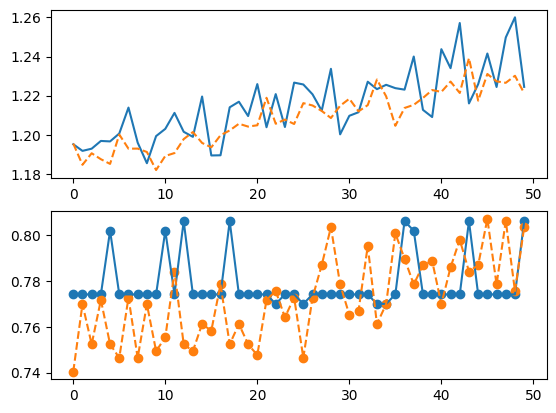

In [507]:
fig, (ax1,ax2) = plt.subplots(2,1)
testloss = np.array(history.history['val_loss']).reshape(len(history.history['val_loss']),1)
trainloss = np.array(history.history['loss']).reshape(len(history.history['loss']),1)

ax1.plot(history.epoch, testloss, '-')
ax1.plot(history.epoch, trainloss, '--')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')

train_precision = np.array(history.history['precision']).reshape(len(history.history['loss']),1)
train_recall= np.array(history.history['recall']).reshape(len(history.history['loss']),1)
j =( 2 * train_precision * train_recall) / (train_precision+train_recall)

test_precission = np.array(history.history['val_precision']).reshape(len(history.history['loss']),1)
test_recall = np.array(history.history['val_recall']).reshape(len(history.history['loss']),1)
k = (2 * test_precission * test_recall )/ (test_precission+test_recall)
# plt.plot(history.epoch,j, '-')
# plt.plot(k,'--')

ax2.scatter(history.epoch, k)
ax2.scatter(history.epoch, j)
ax2.plot(history.epoch, k,'-')
ax2.plot(history.epoch, j,'--')
# ax3.plot(j+3)
# ax3.plot(trainloss,'tab:blue')

In [508]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [509]:
unlabeled_test_sequence = vectorizer_k_best.transform(table_test.sequence).toarray()
# unlabeled_test_sequence = pca.transform(unlabeled_test_sequence)

In [510]:
unlabeled_test_sequence.shape

(350, 80933)

In [516]:
y = model.predict(unlabeled_test_sequence)

11/11 [==============================] - 0s 5ms/step


In [517]:
y

array([[0.35775533],
       [0.34519896],
       [0.35017788],
       [0.34407687],
       [0.34666523],
       [0.34407687],
       [0.34486705],
       [0.35100532],
       [0.3458154 ],
       [0.540002  ],
       [0.35489982],
       [0.3553029 ],
       [0.34460977],
       [0.35777122],
       [0.34407687],
       [0.35511515],
       [0.34407687],
       [0.38512403],
       [0.3473187 ],
       [0.34875947],
       [0.3488631 ],
       [0.34650233],
       [0.34407687],
       [0.34407687],
       [0.3770331 ],
       [0.6750486 ],
       [0.35340336],
       [0.3474783 ],
       [0.34642524],
       [0.3572235 ],
       [0.34910658],
       [0.3551118 ],
       [0.34407687],
       [0.34513488],
       [0.34407687],
       [0.350372  ],
       [0.35440132],
       [0.34879386],
       [0.3564077 ],
       [0.35510084],
       [0.35527146],
       [0.34428728],
       [0.35631803],
       [0.3451753 ],
       [0.34823427],
       [0.34473327],
       [0.34790844],
       [0.344

In [518]:
# for i in range(3):
z = [1 if i>=.5 else 0 for i in y ]

In [519]:
len(z)

350

In [520]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], z))
outfile.close()